In [26]:
import streamlit as st
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import plotly.express as px
import numpy as np

df1 = pd.read_csv('/Users/toby/STADS_Datathon2025/disease_prevelance_simple.csv', sep=',')
print(df1.columns)
# Load the second CSV file (using semicolon as the separator)
df2 = pd.read_csv('/Users/toby/STADS_Datathon2025/20025-03-07_cgm-datathon-challenge-flu_riskgroupsv1.csv', sep=';')
print(df2.columns)
# Merge the two DataFrames on 'Disease' from df2 and 'risk_groups' from df1 using an outer join
merged_df = pd.merge(df1, df2, left_on='Disease', right_on='risk_groups', how='outer')

merged_df = merged_df.drop(columns=['Unnamed: 0'])




Index(['Unnamed: 0', 'Disease', 'Prevelance'], dtype='object')
Index(['week', 'kvregion', 'region', 'specialization', 'gender', 'age_group',
       'insurancecode', 'insurancetype', 'risk_groups', 'absolute',
       'extrapolated'],
      dtype='object')


In [27]:
merged_df.columns

Index(['Disease', 'Prevelance', 'week', 'kvregion', 'region', 'specialization',
       'gender', 'age_group', 'insurancecode', 'insurancetype', 'risk_groups',
       'absolute', 'extrapolated'],
      dtype='object')

In [46]:
df = merged_df.copy()
print(len(df))

35994


In [52]:
3676370/df['extrapolated'].sum()

np.float64(0.2409794843269634)

                 risk_groups  Prevelance  extrapolated
0                     Asthma         6.1        267740
1                       COPD         5.3        249203
2   Chronische Herzkreislauf         7.6        435952
3  Chronische Leberkrankheit         6.2        228705
4                Diabetes T1         7.2         29921
3676370


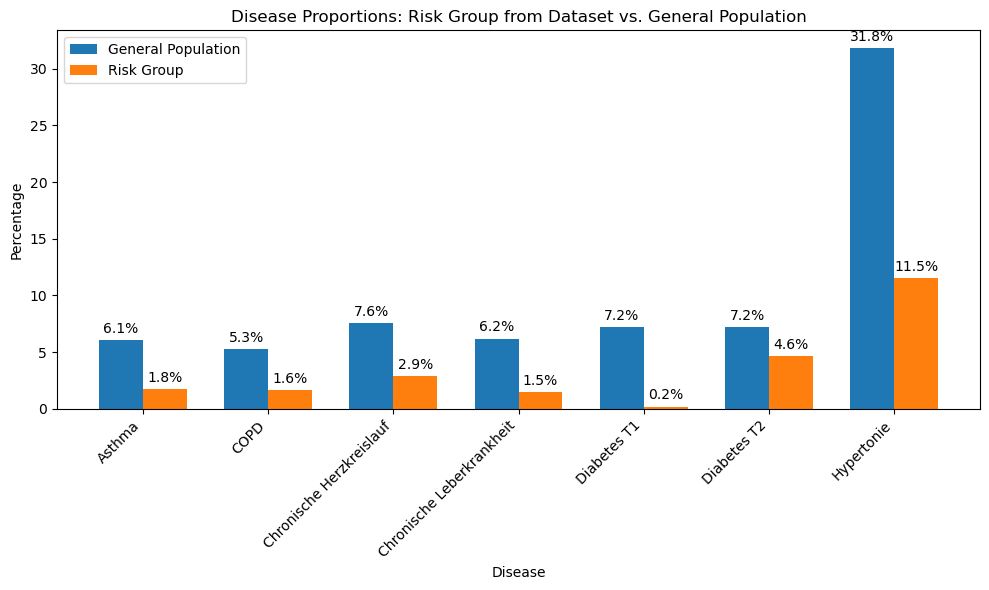

In [61]:
# --- Data Aggregation ---
# Group by 'Disease' and calculate the mean for each percentage column.
agg_df = df.groupby("risk_groups").agg({
    "Prevelance": "mean",      # General population prevalence
    "extrapolated": "sum"       # Risk group proportion
}).reset_index()

print(agg_df.head())
print(agg_df["extrapolated"].sum())

# --- Plotting Setup ---
# Create the x-axis positions for each disease.
x = np.arange(len(agg_df["risk_groups"]))  # one position per disease
width = 0.35  # width of each bar

# Create the figure and axis.
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for general population prevalence.
bars1 = ax.bar(x - width/2, agg_df["Prevelance"], width, label="General Population")

# Plot bars for risk group proportions.
bars2 = ax.bar(x + width/2, (agg_df["extrapolated"]/df['extrapolated'].sum())*100, width, label="Risk Group")

# --- Customizing the Plot ---
ax.set_xlabel("Disease")
ax.set_ylabel("Percentage")
ax.set_title("Disease Proportions: Risk Group from Dataset vs. General Population")
ax.set_xticks(x)
ax.set_xticklabels(agg_df["risk_groups"], rotation=45, ha="right")
ax.legend()

# Optionally, annotate each bar with its height.
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bars1)
autolabel(bars2)

plt.tight_layout()
plt.show()

In [67]:
# --- Data Aggregation ---
# Group by 'Disease' and calculate the mean for each percentage column.
agg_df = df.groupby(["risk_groups", "insurancetype"]).agg({   
    "extrapolated": "sum"       # Risk group proportion
}).reset_index()

agg_df

,risk_groups,insurancetype,extrapolated
0,Asthma,GKV,262525
1,Asthma,PKV,5215
2,COPD,GKV,244811
3,COPD,PKV,4392
4,Chronische Herzkreislauf,GKV,424697
5,Chronische Herzkreislauf,PKV,11255
6,Chronische Leberkrankheit,GKV,221253
7,Chronische Leberkrankheit,PKV,7452
8,Diabetes T1,GKV,29191
9,Diabetes T1,PKV,730


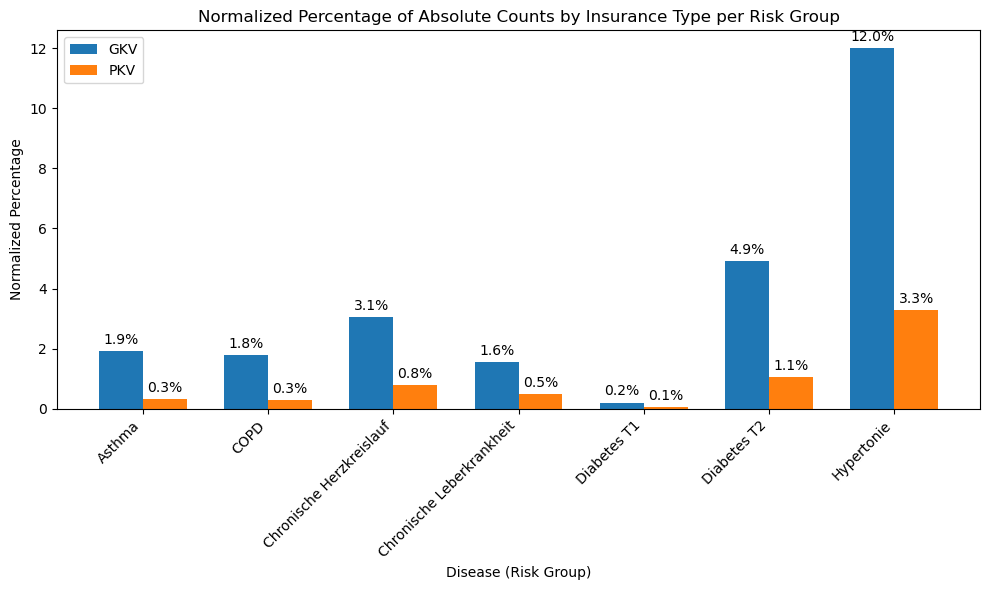

In [68]:
# Assume df is your DataFrame with columns including "risk_groups", "insurancetype", and "absolute"

# 1. Calculate the total count for each insurance type across the dataset.
total_pkv = df.loc[df["insurancetype"] == "PKV", "absolute"].sum()
total_gkv = df.loc[df["insurancetype"] == "GKV", "absolute"].sum()

# 2. Group by 'risk_groups' and 'insurancetype' and sum the 'absolute' values.
agg_df = df.groupby(["risk_groups", "insurancetype"])["absolute"].sum().reset_index()

# 3. Normalize each group's count by the total for its insurance type.
def normalize(row):
    if row["insurancetype"] == "PKV":
        return (row["absolute"] / total_pkv) * 100  # percentage of PKV in that risk group
    elif row["insurancetype"] == "GKV":
        return (row["absolute"] / total_gkv) * 100  # percentage of GKV in that risk group
    else:
        return np.nan

agg_df["normalized"] = agg_df.apply(normalize, axis=1)

# 4. Pivot the table so each risk group becomes a row and each insurance type becomes a column.
pivot_df = agg_df.pivot(index="risk_groups", columns="insurancetype", values="normalized").fillna(0)

# 5. Plot the normalized percentages as a grouped bar chart.
x = np.arange(len(pivot_df.index))  # one position per risk group
width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Get the normalized values for each insurance type.
gkv_vals = pivot_df.get("GKV", pd.Series(np.zeros(len(pivot_df.index)), index=pivot_df.index))
pkv_vals = pivot_df.get("PKV", pd.Series(np.zeros(len(pivot_df.index)), index=pivot_df.index))

bars_gkv = ax.bar(x - width/2, gkv_vals, width, label="GKV")
bars_pkv = ax.bar(x + width/2, pkv_vals, width, label="PKV")

ax.set_xlabel("Disease (Risk Group)")
ax.set_ylabel("Normalized Percentage")
ax.set_title("Normalized Percentage of Absolute Counts by Insurance Type per Risk Group")
ax.set_xticks(x)
ax.set_xticklabels(pivot_df.index, rotation=45, ha="right")
ax.legend()

# Optionally, annotate the bars with percentage values.
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # offset above the bar
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bars_gkv)
autolabel(bars_pkv)

plt.tight_layout()
plt.show()